# 1. 2025년 10월 1일~10일 SNS_COMMUNITY DATA ANALYSIS

## (1) SNS 데이터 워드클라우드

### A. 필요 라이브러리 임포트

In [2]:
import pandas as pd
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
import re

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

### B. 데이터 로드 및 필터링

In [3]:
# 데이터 로드
df = pd.read_csv('./FINAL_SNS_YOUTUBE.csv', encoding='utf-8-sig')

print(f"전체 데이터: {len(df):,}행")
print(f"날짜 범위: {df['date'].min()} ~ {df['date'].max()}")
print(f"\n컬럼: {df.columns.tolist()}")

전체 데이터: 6,382행
날짜 범위: 20250901 ~ 20251031

컬럼: ['date', 'platform', 'type', 'content', 'engagement', 'author', 'url', 'original_date', 'id']


In [8]:
# 2025년 10월 1일~09일 데이터 필터링
start_date = 20251001
end_date = 20251009
df_oct5 = df[(df['date'] >= start_date) & (df['date'] <= end_date)].copy()

print(f"\n{'='*100}")
print(f"2025년 10월 1일~9일 SNS데이터")
print(f"{'='*100}")
print(f"SNS데이터수: {len(df_oct5):,}개")
print(f"\n샘플데이터:")
for i, content in enumerate(df_oct5['content'], 1):
    print(f"{i:2d}. {content}")


2025년 10월 1일~9일 SNS데이터
SNS데이터수: 201개

샘플데이터:
 1. Market Edge ANC 1 October 2025 Heres the news from Market Edge this October 1 2025 Headlines Asian Factory Activity Roundup Philippine Corporate News
 2. 03 October 2025 Market Analysis shorts Nifty showed a strong bullish move today As we shared earlier a Long trade following the market trend could have been taken
 3. Super Red Trade Recovery How I Avoid Panic Selling Near My Entry The Nightmare Scenario Down 3000 on a Single Trade Every trader has been there Youre in a super red trade perhaps
 4. Monthly Market Outlook October 2025 by Prateek Agrawal In this video we share our perspective on the Q1 FY25 results and the key market trends shaping the investment landscape
 5. All Vortex Blue Bot bot trading gather here LOL
 6. 100 leverage 2980 margin on a 298K size would put a shorts liq just above entry within 12 if isolated 2925 is 31 below entryimpossible for that short with that margin
 7. The central bank is addressing the inflatio

In [9]:
# 모든 content를 하나의 문자열로 결합
all_content = ' '.join(df_oct5['content'].dropna().astype(str))

print(f"전체 텍스트 길이: {len(all_content):,}자")
print(f"\n전체 텍스트 샘플 (처음 500자):")
print(all_content[:500])

전체 텍스트 길이: 35,511자

전체 텍스트 샘플 (처음 500자):
Market Edge ANC 1 October 2025 Heres the news from Market Edge this October 1 2025 Headlines Asian Factory Activity Roundup Philippine Corporate News 03 October 2025 Market Analysis shorts Nifty showed a strong bullish move today As we shared earlier a Long trade following the market trend could have been taken Super Red Trade Recovery How I Avoid Panic Selling Near My Entry The Nightmare Scenario Down 3000 on a Single Trade Every trader has been there Youre in a super red trade perhaps Monthly 


### C. 단어 추출 및 정제(불용어 처리 등)

In [10]:
# 단어 추출 및 정제
# 영문 단어만 추출 (최소 3글자 이상)
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# 필수 리소스 다운로드 (이미 했으면 생략 가능)
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# 1. 단어 추출 (소문자 변환 후 정규식)
# all_content가 정의되어 있다고 가정
words = re.findall(r'\b[a-z]{3,}\b', all_content.lower())

# 2. 강력한 불용어 사전 구축
# NLTK 제공 기본 불용어 (i, me, my, myself, we, our... 등 수백 개 포함)
stop_words = set(stopwords.words('english'))

# 사용자 정의 불용어 (오타 수정 및 확장)
custom_stops = {
    # 오타 수정됨 (will, etf 사이 쉼표 등)
    'warpup', 'wrapup', 'wrap',
    'news', 'report', 'reports', 'reported', 'reporting',
    'analysis', 'analyst', 'analysts',
    'say', 'says', 'said', 'saying', 'according',
    'amid', 'update', 'updates', 'latest',
    'today', 'yesterday', 'tomorrow',
    'time', 'year', 'years', 'week', 'weeks', 'day', 'days', 'month', 'months',
    'people', 'investor', 'investors', 'trader', 'traders',
    'good', 'bad', 'new', 'old', 'great',
    'much', 'many', 'high', 'low', 'big', 'small',
    'million', 'billion',
    'hit', 'hits', 'rise', 'rises', 'rising', 'rose',
    'fall', 'falls', 'falling', 'fell',
    'surge', 'surges', 'surging',
    'drop', 'drops', 'dropping',
    'bitcoin', 'btc', 'crypto', 'cryptocurrency',
    'price', 'prices', 'pricing',
    'market', 'markets',
    'stock', 'stocks',
    'ethereum', 'xrp', 'gold',
    'etf', 'etfs',
    'mining', 'miner',
    'record', 'rally',
    'video', 'channel', 'subscribe', 'link',
    'thank', 'thanks',
    'got', 'get', 'getting',
    'now', 'one', 'use', 'make', 'see', 'look', 'watch',
    'like', 'know', 'think', 'going', 'would', 'could', 'should'
}

# 두 집합 합치기
stop_words.update(custom_stops)

# 3. 표제어 추출기(Lemmatizer) 준비
lemmatizer = WordNetLemmatizer()

# 4. 필터링 로직 개선 (핵심!)
# 단어를 원형으로 바꾼 뒤(lemmatize), 그 원형이 불용어 리스트에 있는지 확인합니다.
filtered_words = [
    word for word in words 
    if word not in stop_words  # 1차: 단어 그대로 확인
    and lemmatizer.lemmatize(word) not in stop_words # 2차: 원형으로 바꿔서 확인 (investors -> investor)
    and lemmatizer.lemmatize(word, pos='v') not in stop_words # 3차: 동사 원형 확인 (reported -> report)
]

print(f"------------ 결과 확인 ------------")
print(f"추출된 단어 수 (전): {len(words):,}개")
print(f"추출된 단어 수 (후): {len(filtered_words):,}개")
print(f"제거된 단어 수: {len(words) - len(filtered_words):,}개")
print(f"고유 단어 수: {len(set(filtered_words)):,}개")

# 상위 단어 확인해서 여전히 쓰레기 단어가 있는지 체크
from collections import Counter
print("\n[최종 상위 20개 단어]")
print(Counter(filtered_words).most_common(20))

------------ 결과 확인 ------------
추출된 단어 수 (전): 4,916개
추출된 단어 수 (후): 2,972개
제거된 단어 수: 1,944개
고유 단어 수: 1,602개

[최종 상위 20개 단어]
[('october', 33), ('housing', 28), ('bonds', 26), ('bond', 24), ('real', 21), ('buy', 21), ('estate', 16), ('sir', 15), ('back', 14), ('treasuries', 14), ('still', 13), ('money', 13), ('best', 13), ('rates', 13), ('discussion', 12), ('home', 11), ('buying', 10), ('keep', 10), ('construction', 9), ('sell', 9)]


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [11]:
# 단어 빈도 계산
word_counts = Counter(filtered_words)

print(f"\n{'='*60}")
print("상위 30개 단어")
print(f"{'='*60}")
for i, (word, count) in enumerate(word_counts.most_common(30), 1):
    print(f"{i:2d}. {word:20s} : {count:3d}회")


상위 30개 단어
 1. october              :  33회
 2. housing              :  28회
 3. bonds                :  26회
 4. bond                 :  24회
 5. real                 :  21회
 6. buy                  :  21회
 7. estate               :  16회
 8. sir                  :  15회
 9. back                 :  14회
10. treasuries           :  14회
11. still                :  13회
12. money                :  13회
13. best                 :  13회
14. rates                :  13회
15. discussion           :  12회
16. home                 :  11회
17. buying               :  10회
18. keep                 :  10회
19. construction         :   9회
20. sell                 :   9회
21. interest             :   9회
22. government           :   9회
23. crash                :   9회
24. need                 :   9회
25. risk                 :   9회
26. edge                 :   8회
27. inflation            :   8회
28. really               :   8회
29. might                :   8회
30. portfolios           :   8회


### D. 워드클라우드 생성

✓ 워드클라우드 저장 완료: ./wordcloud_analysis/wordcloud_20251001_20251009.png


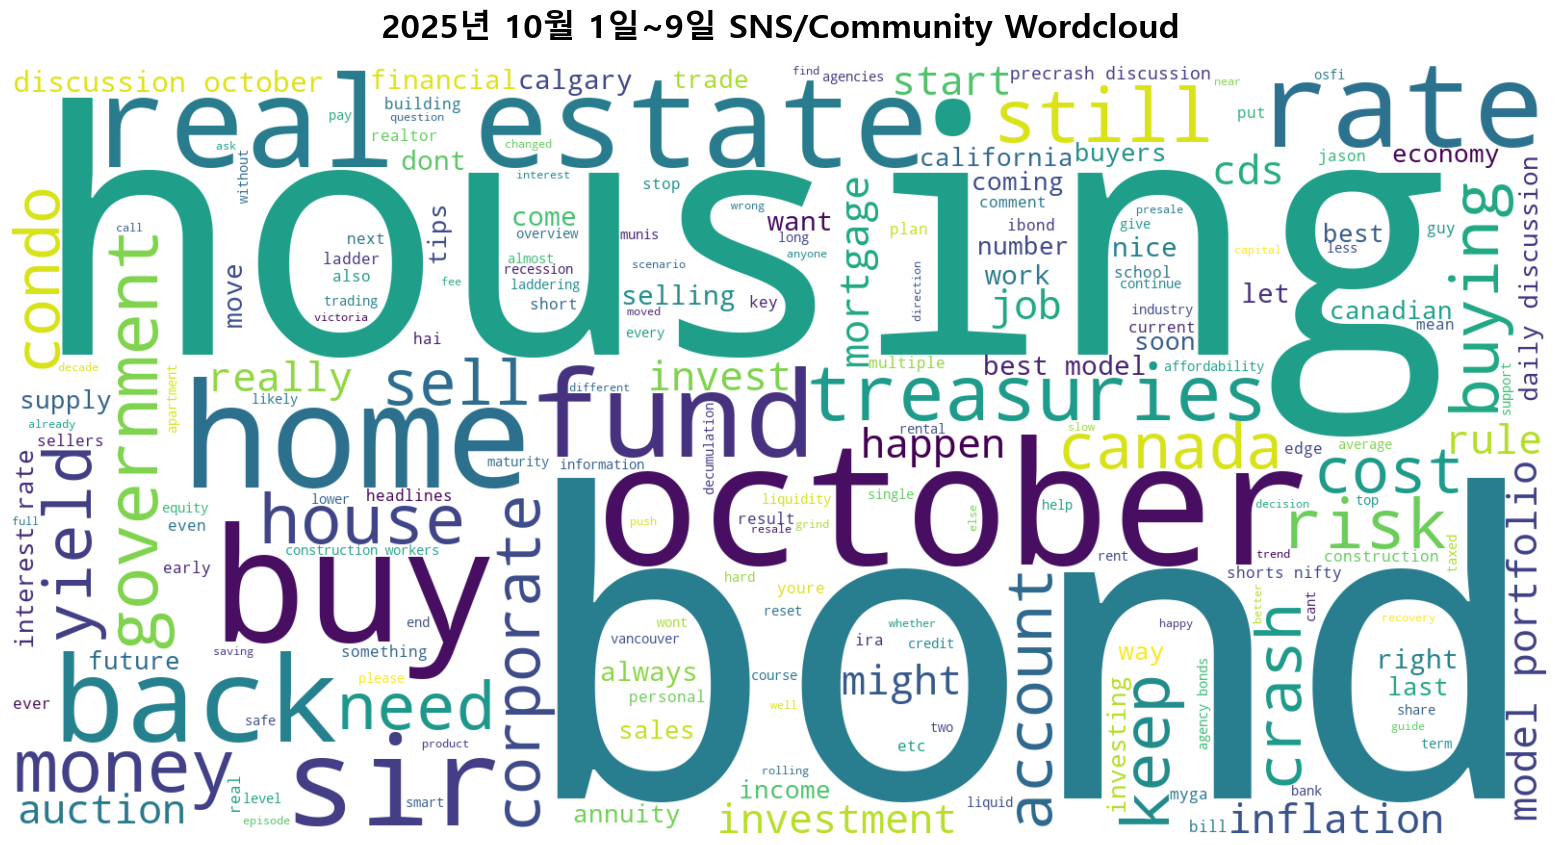

In [12]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import os

# 1. 불용어 설정
my_stop_words = set(stopwords.words('english'))

if 'custom_stops' in locals():
    my_stop_words.update(custom_stops)

# 2. 워드클라우드 생성
wordcloud = WordCloud(
    width=1600,
    height=800,
    background_color='white',
    colormap='viridis',
    relative_scaling=0.5,
    min_font_size=10,
    max_words=200,
    stopwords=my_stop_words 
).generate(' '.join(filtered_words)) # filtered_words 리스트 사용

# 3. 시각화 설정
plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('2025년 10월 1일~9일 SNS/Community Wordcloud', 
          fontsize=24, fontweight='bold', pad=20)

os.makedirs('./wordcloud_analysis', exist_ok=True) 

output_path = './wordcloud_analysis/wordcloud_20251001_20251009.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
print(f"✓ 워드클라우드 저장 완료: {output_path}")

# 5. 화면 출력
plt.show()

# 2. 2025년 10월 10일~19일 SNS_COMMUNITY DATA ANALYSIS

## (1) SNS 데이터 워드클라우드

In [13]:
# 2025년 10월 1일~5일 데이터 필터링
start_date_2 = 20251010
end_date_2 = 20251019
df_oct6 = df[(df['date'] >= start_date_2) & (df['date'] <= end_date_2)].copy()

print(f"\n{'='*100}")
print(f"2025년 10월 10일~19일 SNS데이터")
print(f"{'='*100}")
print(f"SNS데이터수: {len(df_oct6):,}개")
print(f"\n샘플데이터:")
for i_2, content in enumerate(df_oct6['content'], 1):
    print(f"{i_2:2d}. {content}")


2025년 10월 10일~19일 SNS데이터
SNS데이터수: 3,954개

샘플데이터:
 1. Re The Truth About the Current Crypto Market Discussion about Market truth analysis
 2. Re What Really Happened When Crypto Infrastructure Fa Discussion about Infrastructure failure
 3. Re What Really Happened When Crypto Infrastructure Fa Analysis of Infrastructure failure during October crash
 4. The Truth About the Current Crypto Market Community reaction to Market truth analysis
 5. Re What Really Happened When Crypto Infrastructure Fa Technical breakdown of Infrastructure failure
 6. Re The Truth About the Current Crypto Market Technical breakdown of Market truth analysis
 7. Re The Truth About the Current Crypto Market Analysis of Market truth analysis during October crash
 8. Re Surviving the WORST Crash in Crypto History Discussion about Survival guide
 9. Re What Really Happened When Crypto Infrastructure Fa Community reaction to Infrastructure failure
10. Re After record crypto crash rush to hedge Discussion about Postcras

### A. 데이터 로드 및 필터링

In [14]:
# 모든 content를 하나의 문자열로 결합
all_content_2 = ' '.join(df_oct6['content'].dropna().astype(str))

print(f"전체 텍스트 길이: {len(all_content_2):,}자")
print(f"\n전체 텍스트 샘플 (처음 500자):")
print(all_content_2[:500])

전체 텍스트 길이: 391,349자

전체 텍스트 샘플 (처음 500자):
Re The Truth About the Current Crypto Market Discussion about Market truth analysis Re What Really Happened When Crypto Infrastructure Fa Discussion about Infrastructure failure Re What Really Happened When Crypto Infrastructure Fa Analysis of Infrastructure failure during October crash The Truth About the Current Crypto Market Community reaction to Market truth analysis Re What Really Happened When Crypto Infrastructure Fa Technical breakdown of Infrastructure failure Re The Truth About the Cur


### B. 단어 추출 및 정제(불용어 처리 등)

In [38]:
# 단어 추출 및 정제
# 영문 단어만 추출 (최소 3글자 이상)
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# 1. 단어 추출 (소문자 변환 후 정규식)
# all_content_2
words = re.findall(r'\b[a-z]{3,}\b', all_content_2.lower())

# 2. 강력한 불용어 사전 구축
# NLTK 제공 기본 불용어 (i, me, my, myself, we, our... 등 수백 개 포함)
stop_words_2 = set(stopwords.words('english'))

# 사용자 정의 불용어 (오타 수정 및 확장)
custom_stops_2 = {
    # 오타 수정됨 (will, etf 사이 쉼표 등)
    'warpup', 'wrapup', 'wrap',
    'news', 'report', 'reports', 'reported', 'reporting', 'goes', 'post', 'comment', 'come',
    'analysis', 'analyst', 'analysts', 'von', 'ein', 'auch', 'learn', 'already', 'mit', 'talk', 'kiya', 'since',
    'better', 'early', 'ago', 'ein', 'auch', 'car', 'please', 'anyone', 'wbeth', 'ath', 'ein', 'ago', 'von', 'ada',
    'aber', 'kar', 'put', 'around', 'dann', 'win', 'start', 'per', 'ath', 'fund', 'noch', 'car', 'since', 'sold',
    'chart', 'gone', 'comment', 'goes', 'red', 'bag', 'wbeth crash', 'share', 'experience', 'back', 'dan',
    'say', 'says', 'said', 'saying', 'according',
    'amid', 'update', 'updates', 'latest',
    'today', 'yesterday', 'tomorrow',
    'time', 'year', 'years', 'week', 'weeks', 'day', 'days', 'month', 'months',
    'people', 'investor', 'investors', 'trader', 'traders',
    'good', 'bad', 'new', 'old', 'great',
    'much', 'many', 'high', 'low', 'big', 'small',
    'million', 'billion',
    'hit', 'hits', 'rise', 'rises', 'rising', 'rose', 'personal',
    'fall', 'falls', 'falling', 'fell', 'tha', 'mai', 'lot', 'nahi', 'show', 'tha', 'love', 'den',
    'kya', 'bhi', 'auf', 'ich', 'lol', 'believe','yes', 'give', 'follow', 'live', 'hat', 'nur', 'eth', 'way',
    'list', 'key', 'list key', 'den', 'alle', 'data', 'fast', 'que', 'give', 'aur', 'yes', 'reason'
    'surge', 'surges', 'surging',
    'drop', 'drops', 'dropping',
    'bitcoin', 'btc', 'crypto', 'cryptocurrency', 'reaction',
    'price', 'prices', 'pricing',
    'market', 'markets',
    'stock', 'stocks',
    'ethereum', 'xrp', 'gold', 'video', 'like', 'video',
    'etf', 'etfs',
    'mining', 'miner', 'bhai', 'nothing', 'gonna', 'ive', 'feel', 'work', 'invest', 'play', 'still',
    'record', 'rally', 'ist', 'whats', 'mein', 'account', 'right', 'und', 'der', 'best', 'well', 'bei',
    'video', 'channel', 'subscribe', 'link',
    'thank', 'thanks', 'yet', 'thing', 'coin', 'real', 'bro', 'might', 'feel', 'cycle', 'life', 'spot', 'wie',
    'got', 'get', 'getting', 'binance', 'money', 'daily', 'sir', 'let', 'man', 'tell', 'das', 'youre', 'you',
    'now', 'one', 'use', 'make', 'see', 'look', 'watch', 'every'
    'like', 'know', 'think', 'going', 'would', 'could', 'should', 'hai', 'community', 'never', 'dont'
}

# 두 집합 합치기
stop_words_2.update(custom_stops_2)

# 3. 표제어 추출기(Lemmatizer) 준비
lemmatizer_2 = WordNetLemmatizer()

# 4. 필터링 로직 개선 (핵심!)
# 단어를 원형으로 바꾼 뒤(lemmatize), 그 원형이 불용어 리스트에 있는지 확인합니다.
filtered_words_2 = [
    word for word in words 
    if word not in stop_words_2  # 1차: 단어 그대로 확인
    and lemmatizer_2.lemmatize(word) not in stop_words_2 # 2차: 원형으로 바꿔서 확인 (investors -> investor)
    and lemmatizer_2.lemmatize(word, pos='v') not in stop_words_2 # 3차: 동사 원형 확인 (reported -> report)
]

print(f"------------ 결과 확인 ------------")
print(f"추출된 단어 수 (전): {len(words):,}개")
print(f"추출된 단어 수 (후): {len(filtered_words_2):,}개")
print(f"제거된 단어 수: {len(words) - len(filtered_words_2):,}개")
print(f"고유 단어 수: {len(set(filtered_words_2)):,}개")

# 상위 단어 확인해서 여전히 쓰레기 단어가 있는지 체크
from collections import Counter
print("\n[최종 상위 20개 단어]")
print(Counter(filtered_words_2).most_common(20))

------------ 결과 확인 ------------
추출된 단어 수 (전): 54,082개
추출된 단어 수 (후): 29,593개
제거된 단어 수: 24,489개
고유 단어 수: 8,454개

[최종 상위 20개 단어]
[('crash', 663), ('october', 469), ('discussion', 278), ('trump', 256), ('technical', 229), ('breakdown', 212), ('liquidation', 210), ('manipulation', 191), ('whale', 176), ('buy', 168), ('leverage', 162), ('trading', 151), ('liquidated', 116), ('even', 113), ('sell', 105), ('short', 97), ('exchange', 92), ('profit', 86), ('die', 82), ('tariff', 81)]


In [39]:
# 단어 빈도 계산
word_counts_2 = Counter(filtered_words_2)

print(f"\n{'='*60}")
print("상위 30개 단어")
print(f"{'='*60}")
for i_2, (word_2, count_2) in enumerate(word_counts_2.most_common(30), 1):
    print(f"{i_2:2d}. {word_2:20s} : {count_2:3d}회")


상위 30개 단어
 1. crash                : 663회
 2. october              : 469회
 3. discussion           : 278회
 4. trump                : 256회
 5. technical            : 229회
 6. breakdown            : 212회
 7. liquidation          : 210회
 8. manipulation         : 191회
 9. whale                : 176회
10. buy                  : 168회
11. leverage             : 162회
12. trading              : 151회
13. liquidated           : 116회
14. even                 : 113회
15. sell                 : 105회
16. short                :  97회
17. exchange             :  92회
18. profit               :  86회
19. die                  :  82회
20. tariff               :  81회
21. lost                 :  77회
22. largest              :  75회
23. tariffs              :  75회
24. always               :  72회
25. liquidations         :  71회
26. trade                :  70회
27. event                :  69회
28. biggest              :  68회
29. stop                 :  68회
30. long                 :  66회


### C. 워드클라우드 생성

✓ 워드클라우드 저장 완료: ./wordcloud_analysis/wordcloud_20251010_20251019.png


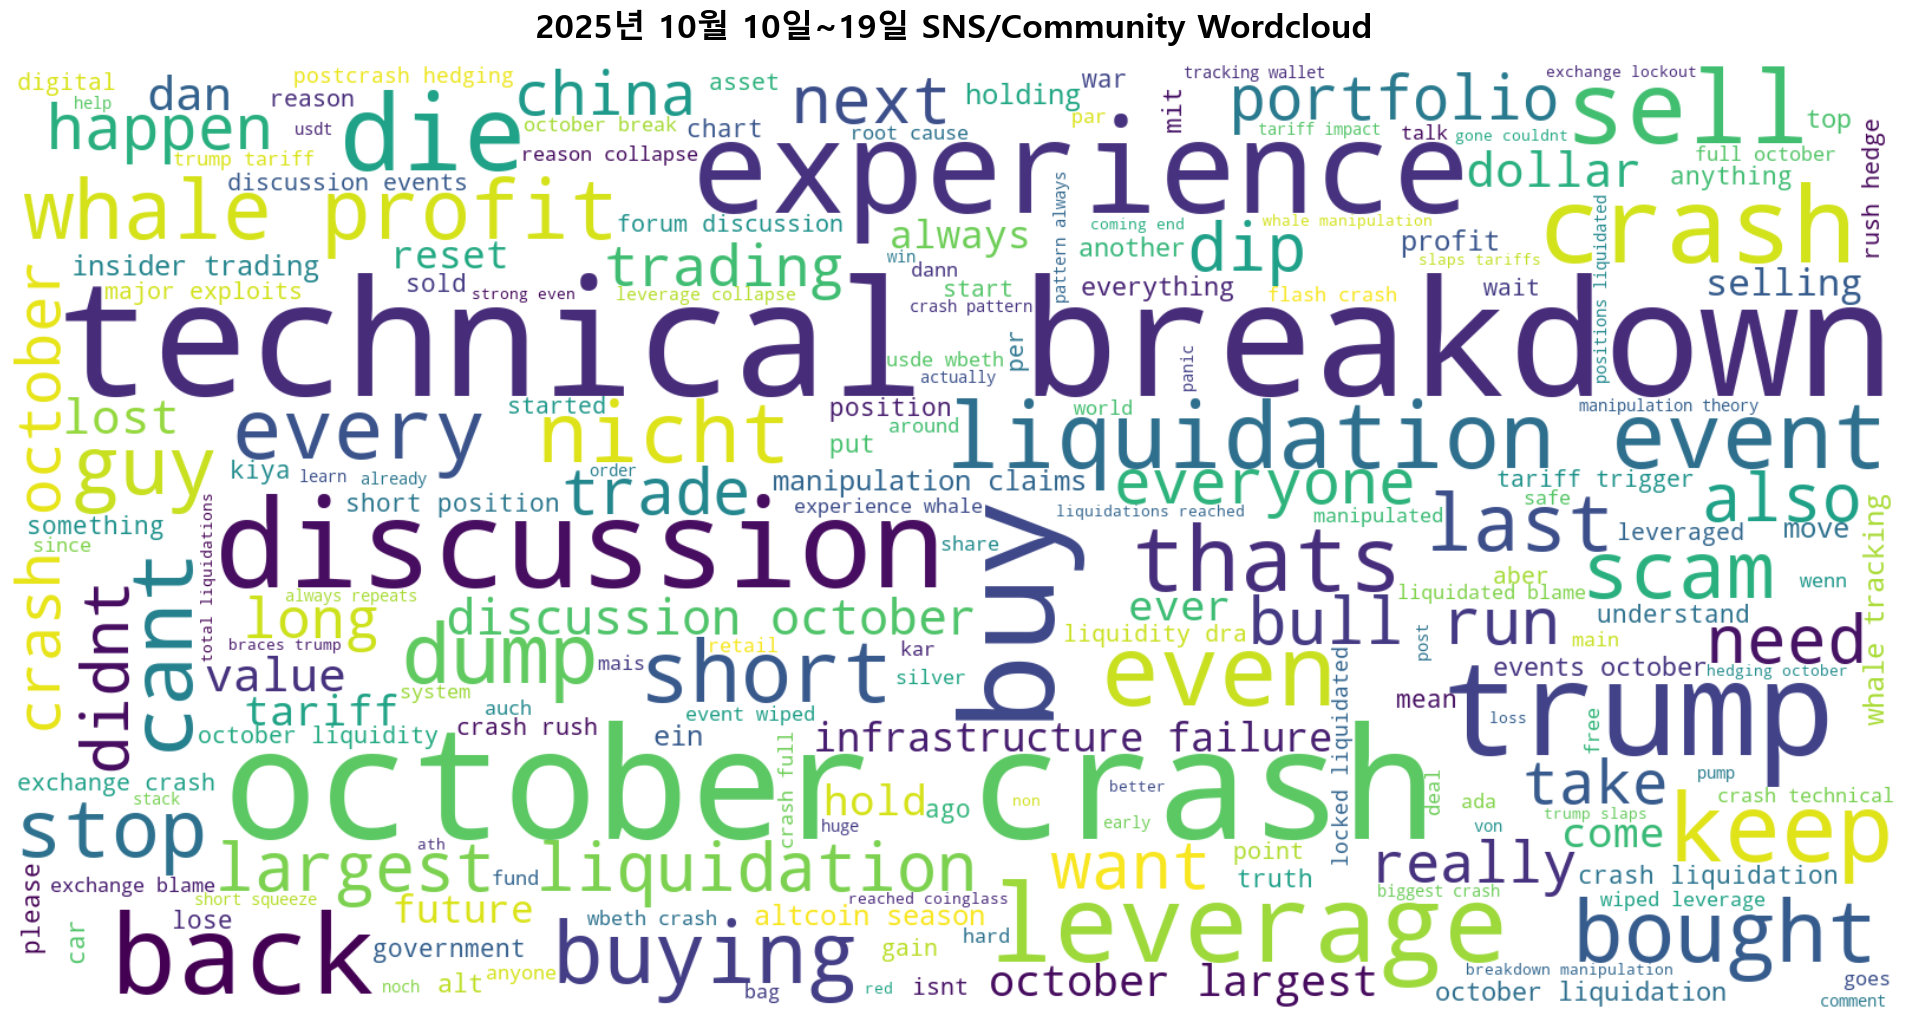

In [36]:
from nltk.corpus import stopwords  # NLTK 도구
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# NLTK 도구에서 'english' 단어장
final_stop_words = set(stopwords.words('english'))

# 사용자 정의 불용어(custom_stops_2) 합치기
if 'custom_stops' in locals():
    final_stop_words.update(custom_stops_2)

# 3. 워드클라우드 생성
wordcloud = WordCloud(
    width=1600,
    height=800,
    background_color='white',
    colormap='viridis',
    relative_scaling=0.5,
    min_font_size=10,
    max_words=200,
    # 🚨 수정된 부분: stopwords 변수 대신 우리가 만든 final_stop_words를 넣습니다.
    stopwords=final_stop_words 
).generate(' '.join(filtered_words_2))

# 4. 시각화
plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('2025년 10월 10일~19일 SNS/Community Wordcloud', 
          fontsize=24, fontweight='bold', pad=20)
plt.tight_layout(pad=0)

# 5. 이미지 저장
import os
os.makedirs('./wordcloud_analysis', exist_ok=True) # 폴더 자동 생성

output_path = './wordcloud_analysis/wordcloud_20251010_20251019.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
print(f"✓ 워드클라우드 저장 완료: {output_path}")

plt.show()